#Use Kaggle to get dataset
However, the heart csv has been provided, this step is ommitted.

In [3]:
!pip install -q kaggle

#Import libraries

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import sklearn as sk
import os
from IPython.display import clear_output, display

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier

try:
  from treeinterpreter import treeinterpreter as ti
except:
  !pip install treeinterpreter
  from treeinterpreter import treeinterpreter as ti

from sklearn.tree import DecisionTreeClassifier, plot_tree

#Read CSV file.

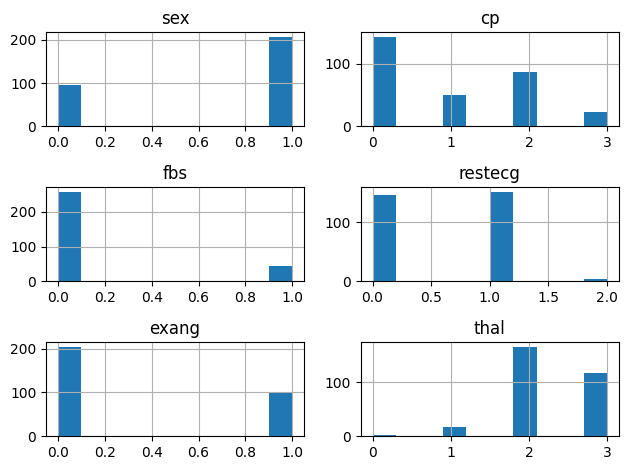

In [5]:
df = pd.read_csv('/content/heart.csv')

df[['sex','cp','fbs','restecg','exang','thal']].hist()
plt.tight_layout()

#Create training sets, validation sets and testing sets respectively.

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2)
train, valid = train_test_split(train, test_size = 0.1)

train_x = train.copy()
train_y = train_x.pop('target')
valid_x = valid.copy()
valid_y = valid_x.pop('target')
test_x = test.copy()
test_y = test_x.pop('target')

pd.concat([train_x, train_y], axis = 1).head()
df.iloc[[80,59,186],:].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
80,41,1,2,112,250,0,1,179,0,0.0,2,0,2,1
59,57,0,0,128,303,0,0,159,0,0.0,2,1,2,1
186,60,1,0,130,253,0,1,144,1,1.4,2,1,3,0


#Change data format in order to suit the needs for Classifier Training.

In [7]:
fc = tf.feature_column
NUMERIC_COLUMNS = ['age','trestbps','chol','thalach','oldpeak','slope','ca']
BUCKETIZED_COLUMNS = [(feature_column.numeric_column('age', dtype = tf.float32), list(np.linspace(15,65,11)))]
CATEGORICAL_COLUMNS = ['sex','cp','fbs','restecg','exang']

EMBEDDING_COLUMNS = []

HASHED_COLUMNS = [('thal',100)]
CROSSED_COLUMNS = [(feature_column.bucketized_column(feature_column.numeric_column('age', dtype = tf.float32), list(np.linspace(15,65,11))),
                     feature_column.categorical_column_with_vocabulary_list('thal',train_x['thal'].unique(),dtype = tf.int32), 100)]

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [8]:
feature_columns = []

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(feature_column.numeric_column(feature_name,dtype = tf.float32))

for (nc, boundaries) in BUCKETIZED_COLUMNS:
  feature_columns.append(feature_column.bucketized_column(nc, boundaries = boundaries))

for feature_name in CATEGORICAL_COLUMNS:
  vocab = train_x[feature_name].unique()
  one_hot = feature_column.categorical_column_with_vocabulary_list(feature_name,vocab)
  feature_columns.append(feature_column.indicator_column(one_hot))

for (c_fc, dim) in EMBEDDING_COLUMNS:
  ec = feature_column.embedding_column(c_fc, dimension = dim)
  feature_columns.append(ec)

for (feature_name, hash_bucket_size) in HASHED_COLUMNS:
  hashed_bucket = feature_column.categorical_column_with_hash_bucket(feature_name, hash_bucket_size = hash_bucket_size, dtype = tf.int32)
  feature_columns.append(feature_column.indicator_column(hashed_bucket))

for (f1,f2, hash_bucket_size) in CROSSED_COLUMNS:
  crossed_feature = feature_column.crossed_column([f1,f2], hash_bucket_size = hash_bucket_size)
  feature_columns.append(feature_column.indicator_column(crossed_feature))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


#Use tensorflow to create data input pipeline.

In [9]:
def make_input_fn(X, y, n_epochs = None, shuffle = True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X),y))
    if shuffle:
      dataset = dataset.shuffle(len(y))
    dataset = dataset.repeat(n_epochs)
    dataset = dataset.batch(len(y))
    return dataset

  return input_fn

train_input_fn = make_input_fn(train_x, train_y)
valid_input_fn = make_input_fn(valid_x, valid_y)
test_input_fn = make_input_fn(test_x, test_y,1)

#Neural Network

In [10]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(train_input_fn(), epochs = 30, validation_data = valid_input_fn(), steps_per_epoch = 10, validation_steps = 10, verbose = 0)
results = model.evaluate(test_input_fn(), verbose = 0)
pd.Series({'loss': results[0], 'acc': results[1]}).to_frame()

,0
loss,0.391337
acc,0.852459


In [11]:
tf.__version__

'2.15.0'

#Using BoostedTreesClassifier in tensorflow.

In [12]:
params = {
    'n_trees' : 50,
    'max_depth' : 3,
    'n_batches_per_layer' : 1,
    'center_bias' : True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

est.train(train_input_fn, max_steps = 100)

results = est.evaluate(test_input_fn)
clear_output()
pd.Series(results).to_frame()

AttributeError: module 'tensorflow_estimator.python.estimator.api._v2.estimator' has no attribute 'BoostedTreesClassifier'

#Data checking.

In [ ]:
pd.DataFrame({name:[v] for name, v in est.experimental_feature_importances().items()}).T

In [ ]:
#check DFC of training module.
pred_dicts = list(est.experimental_predict_with_explanations(make_input_fn(train_x, train_y, 1)))

df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.abs().describe().T.sort_values(['mean'], ascending = False)

In [ ]:
#check DFC of sample module.
pred_dicts = list(est.experimental_predict_with_explanations(make_input_fn(test_input_fn)))

df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.abs().describe().T.sort_values(['mean'], ascending = False)

In [ ]:
#check DFC of sample.
pd.DataFrame([pred_dicts[2]['dfc']]).abs().head(1).T

#Using RandomForestClassifier in sklearn.

In [13]:
rf_clf = RandomForestClassifier(random_state = 96)
rf_clf.fit(train_x, train_y)
rf_acc = rf_clf.score(test_x, test_y)
print("acc: {:.3f}".format(rf_acc))

acc: 0.836


#Data checking.

In [16]:
pd.DataFrame({name:[cr] for cr, name in zip(rf_clf.feature_importances_, train_x.columns)}).head().T.sort_values([0], ascending = False)

,0
cp,0.160616
oldpeak,0.124697
ca,0.110824
thalach,0.109135
thal,0.100386
age,0.080875
trestbps,0.074014
chol,0.069942
exang,0.057064
slope,0.047367


In [ ]:
#Check DFC for Training Module.

prediction, bias, contributions = ti.predict(rf_clf, train_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
  class_id = np.argmax(p)
  contrib.append(np.abs(np.array(c)[:, class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib), axis = 0))}).head().T.sort_values([0], ascending = False)

In [ ]:
#Check DFC for Testing Module.

prediction, bias, contributions = ti.predict(rf_clf, test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
  class_id = np.argmax(p)
  contrib.append(np.abs(np.array(c)[:, class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib), axis = 0))}).head().T.sort_values([0], ascending = False)

In [ ]:
#Check DFC for Specified Module.

instance_id = 10
prediction, bias, contributions = ti.predict(rf_clf, test_x[instance_id: instance_id + 1])
class_id = np.argmax(prediction[0,:])
pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.abs(np.array(contributions[0,:, class_id])).ravel())}).head().T.sort_values([0],ascending = False)

#Using DecisionTreeClassifier from sklearn.

In [22]:
dt_clf = DecisionTreeClassifier(random_state = 96)
dt_clf.fit(train_x,train_y)
dt_acc = dt_clf.score(test_x, test_y)
print('acc: {:.3f}'.format(dt_acc))

acc: 0.836


#Data checking.

dt_clf.importances will record every attribute in a record, this can reduce data uncertainty when building the Random Forest, attributes with a higher value has a higher importance.

In [ ]:
pd.DataFrame({name:[cr] for cr, name in zip(dt_clf.feature_importances_, train_x.columns)}).head().T.sort_values([0], ascending = False)

Display the structure of the Decision Tree.

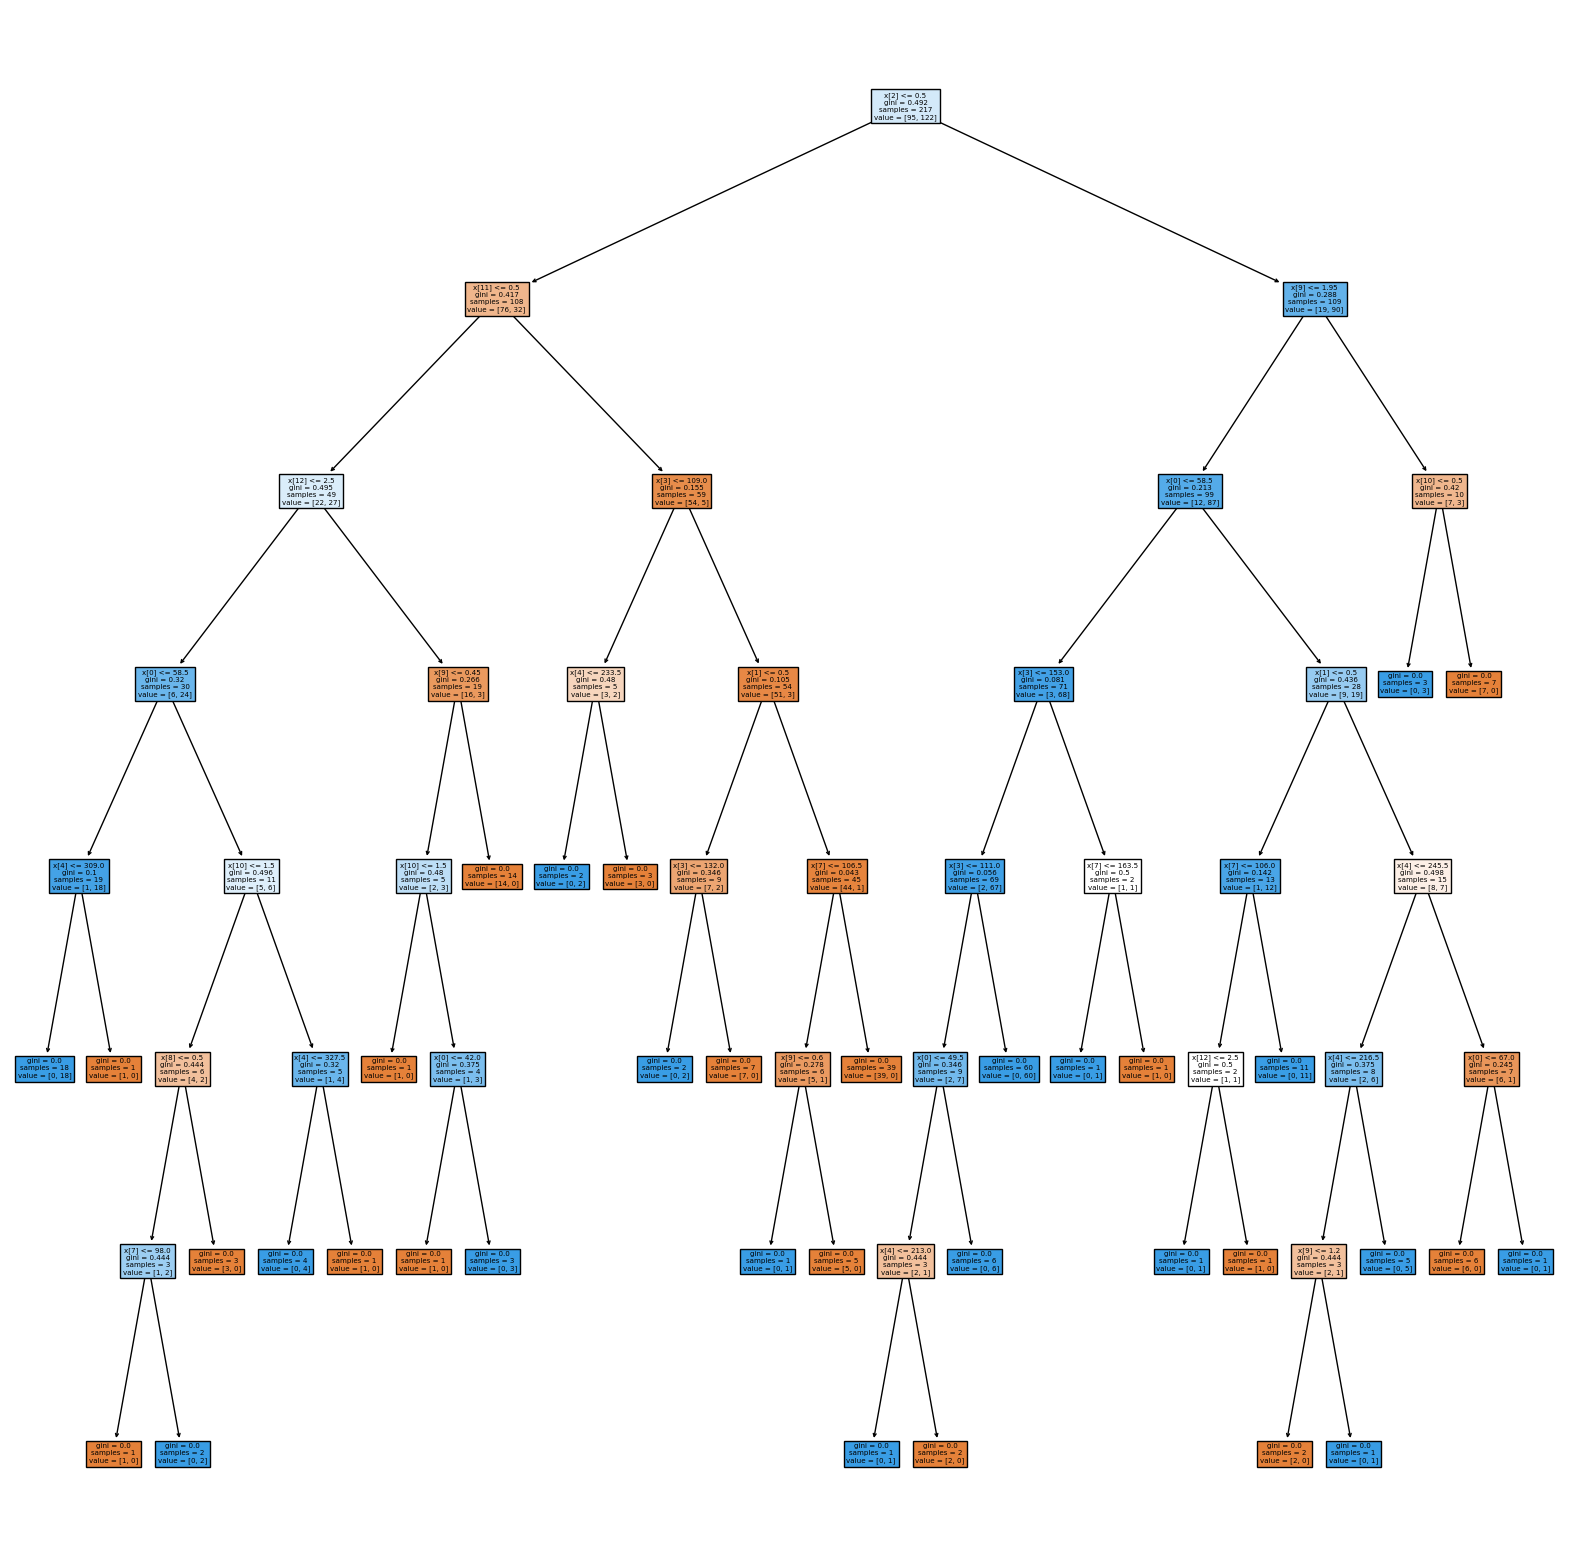

In [23]:
plt.figure(figsize = (20,20))
a = plot_tree(dt_clf, filled =True)
plt.savefig('decision_tree.pdf')

In [24]:
#Check DFC for Training Module.

prediction, bias, contributions = ti.predict(dt_clf, train_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
cp,0.264690
ca,0.115037
age,0.100548
oldpeak,0.081670
thal,0.073451
chol,0.057887
trestbps,0.051693
sex,0.043120
slope,0.036615
thalach,0.026539


In [25]:
#Check DFC for Sampling Module.

prediction, bias, contributions = ti.predict(dt_clf, test_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
cp,0.264436
age,0.128646
oldpeak,0.107502
ca,0.089603
chol,0.073931
trestbps,0.054862
thal,0.048550
sex,0.044683
slope,0.037084
thalach,0.016884


In [26]:
#Check DFC for a Specific Sample.

instance_id = 10
prediction, bias, contributions = ti.predict(dt_clf, test_x[instance_id:instance_id+1])
class_id = np.argmax(prediction[0,:])
pd.DataFrame({name:[cr] for name, cr in zip(test_x.columns, np.abs(np.array(contributions[0,:,class_id])).ravel())}).head().T.sort_values([0],ascending=False)

,0
oldpeak,0.719766
cp,0.263476
sex,0.211905
age,0.200216
chol,0.133333
trestbps,0.000000
fbs,0.000000
restecg,0.000000
thalach,0.000000
exang,0.000000


In [30]:
def extract_rules(clf,names=None):
    def dfs(node_id,precond):
        if clf.tree_.children_left[node_id]==-1 and clf.tree_.children_right[node_id]==-1: # a leaf node
            val = clf.tree_.value[node_id].ravel()
            pp  = val/np.sum(val)
            pp  = ','.join(['{:.3f}'.format(x) for x in pp])
            pr  = ' and '.join(precond)
            rules.append('if '+ pr +' then ' + 'class {}, '.format(np.argmax(val)) + 'posterior prob. ['+ pp +']')
            return
        if clf.tree_.children_left[node_id] >= 0:
            new_precond = precond.copy()
            new_precond.append('{}<={:.3f}'.format(names[clf.tree_.feature[node_id]],clf.tree_.threshold[node_id]))
            dfs(clf.tree_.children_left[node_id], new_precond)
        if clf.tree_.children_right[node_id] >= 0:
            new_precond = precond.copy()
            new_precond.append('{}>{:.3f}'.format(names[clf.tree_.feature[node_id]],clf.tree_.threshold[node_id]))
            dfs(clf.tree_.children_right[node_id], new_precond)
        return
#-------------------------------------------------
    if names is None:
        names = ['f_{}'.format(x) for x in range(clf.tree_.n_features)]

    rules = []
    precond=[]
    dfs(0,precond)
    return rules

extract_rules(dt_clf,train_x.columns)

['if cp<=0.500 and ca<=0.500 and thal<=2.500 and age<=58.500 and chol<=309.000 then class 1, posterior prob. [0.000,1.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and age<=58.500 and chol>309.000 then class 0, posterior prob. [1.000,0.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and age>58.500 and slope<=1.500 and exang<=0.500 and thalach<=98.000 then class 0, posterior prob. [1.000,0.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and age>58.500 and slope<=1.500 and exang<=0.500 and thalach>98.000 then class 1, posterior prob. [0.000,1.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and age>58.500 and slope<=1.500 and exang>0.500 then class 0, posterior prob. [1.000,0.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and age>58.500 and slope>1.500 and chol<=327.500 then class 1, posterior prob. [0.000,1.000]',
 'if cp<=0.500 and ca<=0.500 and thal<=2.500 and age>58.500 and slope>1.500 and chol>327.500 then class 0, posterior prob. [1.000,0.000]',
 'if cp<=0.500

#Using tf.data and sklearn's Random Forest Classifier and Decision Tree Classifier

In [31]:
fc_train_x = feature_layer(dict(train_x)).numpy()
fc_test_x  = feature_layer(dict(test_x)).numpy()

In [32]:
rf_clf.fit(fc_train_x,train_y)
rf_acc = rf_clf.score(fc_test_x,test_y)
print("RandomForest test accuracy:{:.3f}".format(rf_acc))

dt_clf.fit(fc_train_x,train_y)
dt_acc = dt_clf.score(fc_test_x,test_y)
print("DecisionTree test accuracy:{:.3f}".format(dt_acc))

RandomForest test accuracy:0.836
DecisionTree test accuracy:0.803


#Conclusion  
  
Using Forest Classifiers can help in grouping data with similar attributes.  
Although I cannot run the Boosted Tree Classifier, I have learned how a Random Forest and Decision Tree could help in grouping data.